In [2]:
import pandas as pd
import numpy as np
import mygene as mygene
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.preprocessing import StandardScaler
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.preprocessing import deseq2_norm
from pydeseq2.utils import load_example_data

# Data Preprocessing

In [28]:
#df = pd.read_csv('SRP158491/SRP158491.tsv', sep='\t')

In [29]:
'''
mg = mygene.MyGeneInfo()
query_result = mg.querymany(df['Gene'].tolist(), scopes='ensembl.gene',
                           fields='symbol', species='human')
ensembl_to_hugo = {item['query']: item.get('symbol', '') for item in query_result}
df['Gene'] = df['Gene'].map(ensembl_to_hugo)
df.to_csv('SRP158491_converted.tsv', sep='\t', index=False)
'''

6 input query terms found dup hits:	[('ENSG00000188660', 2), ('ENSG00000249738', 2), ('ENSG00000268674', 3), ('ENSG00000273730', 10), ('
447 input query terms found no hit:	['ENSG00000112096', 'ENSG00000116883', 'ENSG00000130489', 'ENSG00000130723', 'ENSG00000137808', 'ENS


In [3]:
df = pd.read_csv('SRP158491_converted.tsv', sep='\t')

In [4]:
### HUgo Values not matching Ensemble IDs so dropping NAN Values
df = df.dropna()

In [5]:
df = df.drop_duplicates(subset='Gene', keep='first')

In [6]:
df

,Gene,SRR7725764,SRR7725765,SRR7725767,SRR7725768,SRR7725770,SRR7725772,SRR7725773,SRR7725774,SRR7725775,...,SRR7726082,SRR7726083,SRR7726089,SRR7726092,SRR7726094,SRR7726095,SRR7726096,SRR7726097,SRR7726098,SRR7726099
0,TSPAN6,3.136188,5.375076,0.291745,0.258578,6.014666,4.883872,21.46048,3.386398,0.000000,...,13.731706,1.645844,3.188051,17.539990,2.125112,14.213586,8.422800,0.00000,1.620008,14.032206
1,TNMD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.768578,0.000000
2,DPM1,68.181700,131.896120,34.899677,562.589700,140.499310,323.004700,464.93018,416.068080,337.545700,...,387.810150,421.635700,323.789670,301.299040,402.624940,422.879670,442.268550,404.41415,556.072940,139.260510
3,SCYL3,77.735520,42.363340,48.085857,110.548100,52.349422,120.034096,145.88985,128.955440,90.929340,...,169.642030,114.807370,85.415245,87.620575,117.897720,160.923280,131.868960,103.09869,96.676780,49.404740
4,FIRRM,18.562527,23.658604,15.999660,32.007370,18.406652,38.122380,38.92119,32.574413,43.490807,...,53.578606,53.470234,64.275110,28.295240,56.696815,46.024033,29.202042,38.10093,36.457996,16.427351
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43318,LOC128092249,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
43330,ARMCX5-GPRASP2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.944950,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
43336,LOC112268419,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
43348,LOC124903324,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000


# Step 1

## Log Scaling

In [12]:
### Need To Log-Scale Values For Plot of Medians
test = df.copy()
test.iloc[:, 1:] = np.log1p(df.iloc[:, 1:])

In [13]:
median_expression = test.iloc[:, 1:].median(axis=1)

Text(0.5, 0, 'Log Counts')

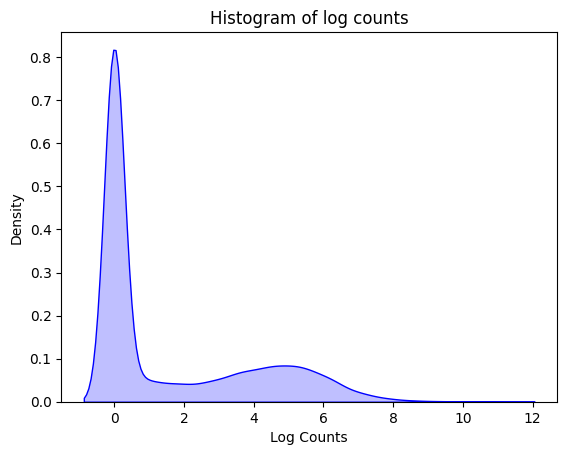

In [17]:
sns.kdeplot(median_expression.clip(0, 12), color='blue', fill=True)
plt.title('Histogram of log counts')
plt.ylabel('Density')
plt.xlabel('Log Counts')

Text(0.5, 0, 'Log Counts')

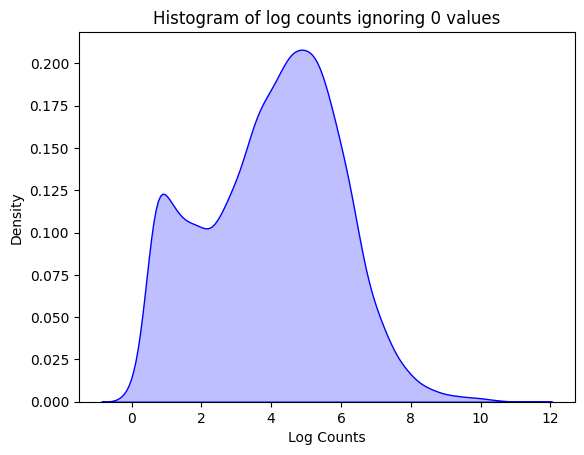

In [18]:
sns.kdeplot(median_expression[median_expression > 0], color='blue', fill=True)
plt.title('Histogram of log counts ignoring 0 values')
plt.ylabel('Density')
plt.xlabel('Log Counts')

# Step 2

In [12]:
### Step 2
import json

In [13]:
with open('aggregated_metadata.json') as file:
    data = json.load(file)


## Getting Dataframes for Each group according to metadata

In [14]:
### Create Healthy and Rheumatoid Dataframes
healthy_indices = ['Gene']
rheumatoid_indices = ['Gene']
ifx_indices = ['Gene']
mtx_indices = ['Gene']
non_indices = ['Gene']
tcz_indices = ['Gene']
synovial_indices = ['Gene']
for column in df.columns:
    if(column == 'Gene'):
        continue
    elif data['samples'][column]['refinebio_disease'] == 'healthy':
        healthy_indices.append(column)
    elif data['samples'][column]['refinebio_disease'] == 'ra ifx treatment':
        rheumatoid_indices.append(column)
        ifx_indices.append(column)
    elif data['samples'][column]['refinebio_disease'] == 'ra mtx treatment':
        rheumatoid_indices.append(column)
        mtx_indices.append(column)
    elif data['samples'][column]['refinebio_disease'] == 'ra non treatment':
        rheumatoid_indices.append(column)
        non_indices.append(column)
    elif data['samples'][column]['refinebio_disease'] == 'ra tcz treatment':
        rheumatoid_indices.append(column)
        tcz_indices.append(column)
    else:
        rheumatoid_indices.append(column)
        synovial_indices.append(column)

In [15]:
print(len(healthy_indices))
print(len(rheumatoid_indices))
print(len(ifx_indices))
print(len(mtx_indices))
print(len(non_indices))
print(len(tcz_indices))
print(len(synovial_indices))

63
215
55
49
58
47
10


In [16]:
len(rheumatoid_indices)

215

In [17]:
healthy_df = test[healthy_indices]
rheumatoid_df = test[rheumatoid_indices]
ifx_df = test[ifx_indices]
mtx_df = test[mtx_indices]
non_df = test[non_indices]
tcz_df = test[tcz_indices]
synovial_df = test[synovial_indices]

In [18]:
rheumatoid_df

,Gene,SRR7725833,SRR7725834,SRR7725835,SRR7725836,SRR7725837,SRR7725838,SRR7725841,SRR7725842,SRR7725843,...,SRR7726082,SRR7726083,SRR7726089,SRR7726092,SRR7726094,SRR7726095,SRR7726096,SRR7726097,SRR7726098,SRR7726099
0,TSPAN6,2.382957,0.233442,3.457217,1.871166,0.488436,2.445236,2.281587,0.000000,0.877748,...,2.690002,0.972990,1.432236,2.919930,1.139470,2.722189,2.243132,0.000000,0.963177,2.710195
1,TNMD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.570176,0.000000
2,DPM1,5.487779,5.550531,5.496561,5.243877,2.445244,4.957591,5.883984,6.156345,5.896875,...,5.963091,6.046511,5.783178,5.711417,6.000486,6.049450,6.094176,6.004909,6.322696,4.943501
3,SCYL3,4.515617,3.980853,4.015447,3.667109,2.223991,3.668026,4.500932,4.773943,4.737823,...,5.139568,4.751928,4.459164,4.484364,4.778264,5.087123,4.889363,4.645339,4.581664,3.920085
4,FIRRM,4.027941,3.849665,3.217186,3.766064,2.847837,3.163431,3.010587,3.184986,3.856301,...,3.999642,3.997654,4.178611,3.377425,4.055202,3.850659,3.407910,3.666146,3.623220,2.858041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43318,LOC128092249,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
43330,ARMCX5-GPRASP2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.665236,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
43336,LOC112268419,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
43348,LOC124903324,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [19]:
synovial_df

,Gene,SRR7726022,SRR7726023,SRR7726024,SRR7726026,SRR7726027,SRR7726028,SRR7726030,SRR7726031,SRR7726032
0,TSPAN6,0.000000,0.000000,0.000000,0.425417,2.626989,0.235325,0.980853,0.000000,0.000000
1,TNMD,0.000000,0.000000,1.033827,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,DPM1,5.402469,4.065557,2.972173,4.344642,5.446996,4.765527,5.463734,6.079458,5.841157
3,SCYL3,4.168421,3.366162,2.681596,3.083260,3.945768,3.195280,3.456482,4.073202,4.321153
4,FIRRM,4.008173,3.816135,2.288200,3.325019,3.249893,3.860204,3.315098,3.638068,4.221693
...,...,...,...,...,...,...,...,...,...,...
43318,LOC128092249,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
43330,ARMCX5-GPRASP2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
43336,LOC112268419,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
43348,LOC124903324,0.000000,0.000000,0.000000,0.000000,0.000000,0.610919,0.000000,0.000000,0.000000


In [20]:
from sklearn.decomposition import PCA

In [118]:
pca = PCA(n_components=2)
pca.fit(test.iloc[:, 1:].transpose())

PCA(n_components=2)

In [119]:
len(pca.components_[0])

31644

In [120]:
rheumatoid_df = test[rheumatoid_indices]
ifx_df = test[ifx_indices]
mtx_df = test[mtx_indices]
non_df = test[non_indices]
tcz_df = test[tcz_indices]
synovial_df = test[synovial_indices]

In [121]:
healthy_pca = pca.transform(healthy_df.iloc[:, 1:].transpose())
rheumatoid_pca = pca.transform(rheumatoid_df.iloc[:, 1:].transpose())
ifx_pca = pca.transform(ifx_df.iloc[:, 1:].transpose())
mtx_pca = pca.transform(mtx_df.iloc[:, 1:].transpose())
non_pca = pca.transform(non_df.iloc[:, 1:].transpose())
tcz_pca = pca.transform(tcz_df.iloc[:, 1:].transpose())
synovial_pca = pca.transform(synovial_df.iloc[:, 1:].transpose())

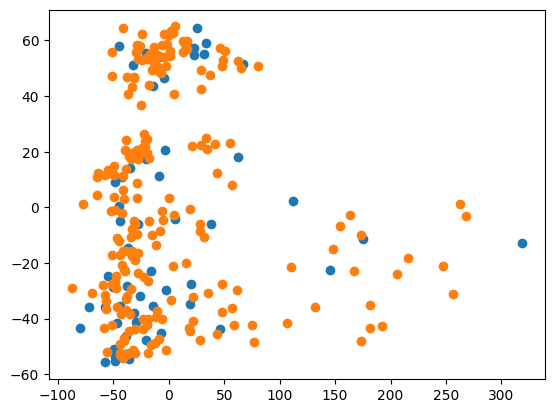

In [122]:
plt.scatter(healthy_pca[:, 0], healthy_pca[:, 1])
plt.scatter(rheumatoid_pca[:, 0], rheumatoid_pca[:, 1])

In [40]:
test = df

## Healthy Non-Treatment PCA

Text(0, 0.5, 'Principal Component 2')

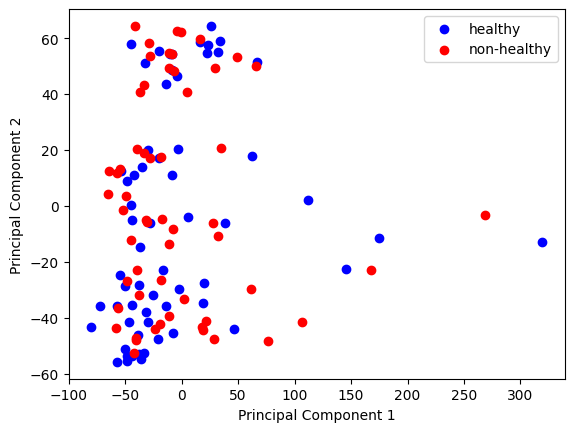

In [123]:
plt.scatter(healthy_pca[:, 0], healthy_pca[:, 1], c='blue', label='healthy')
plt.scatter(non_pca[:, 0], non_pca[:, 1], c='red', label='non-healthy')
plt.legend()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

## All treatments PCA

In [124]:
rheumatoid_df = test[rheumatoid_indices]
ifx_df = test[ifx_indices]
mtx_df = test[mtx_indices]
non_df = test[non_indices]
tcz_df = test[tcz_indices]
synovial_df = test[synovial_indices]

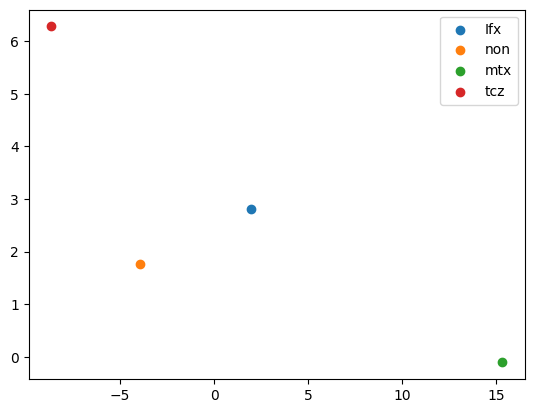

In [125]:
plt.scatter(np.mean(ifx_pca[:, 0]), np.mean(ifx_pca[:, 1]), label='Ifx')
plt.scatter(np.mean(non_pca[:, 0]), np.mean(non_pca[:, 1]), label='non')
plt.scatter(np.mean(mtx_pca[:, 0]), np.mean(mtx_pca[:, 1]), label='mtx')
plt.scatter(np.mean(tcz_pca[:, 0]), np.mean(tcz_pca[:, 1]), label='tcz')
plt.legend()

## T-SNE Boogaloo

In [25]:
from sklearn.manifold import TSNE

In [26]:
tsne = TSNE(n_components=2).fit_transform(test.iloc[:, 1:].transpose())

In [31]:
tsne_df = pd.DataFrame(data = tsne, index=test.iloc[:, 1:].transpose().index)

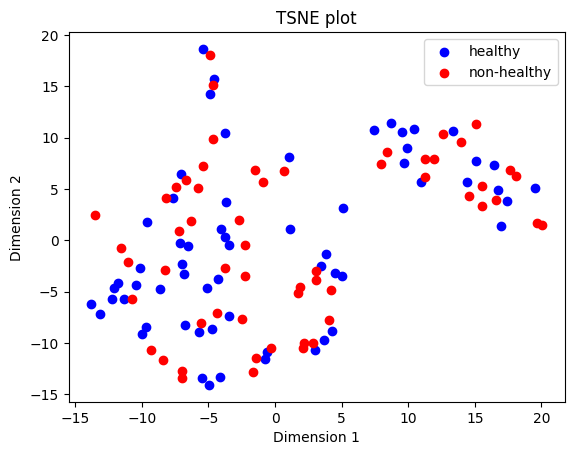

In [32]:
plt.scatter(tsne_df.loc[healthy_indices[1:]][0], tsne_df.loc[healthy_indices[1:]][1], c = 'blue', label='healthy')
plt.scatter(tsne_df.loc[non_indices[1:]][0], tsne_df.loc[non_indices[1:]][1], c = 'red', label = 'non-healthy')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('TSNE plot')
plt.legend()

## UMAP Boogaloo

In [10]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(test.iloc[:, 1:].transpose())

In [11]:
embedding

array([[ 7.5433245 ,  8.938527  ],
       [ 8.097057  ,  9.877441  ],
       [ 6.7715316 ,  9.796984  ],
       [ 8.45415   , 11.35768   ],
       [ 7.5406027 ,  2.6340334 ],
       [ 9.714728  , 12.31482   ],
       [ 6.174892  ,  0.6831234 ],
       [11.4121065 , 11.249421  ],
       [ 8.335476  , 13.078867  ],
       [ 8.352567  , 13.144257  ],
       [ 5.9051485 ,  1.3492155 ],
       [10.123148  ,  8.542047  ],
       [ 9.420783  , 10.788958  ],
       [ 7.8646393 ,  1.9073286 ],
       [ 8.270868  , 11.233962  ],
       [ 7.490587  ,  2.6663654 ],
       [10.372503  ,  8.755194  ],
       [ 9.316588  , 10.68378   ],
       [-5.47155   , 10.521228  ],
       [-5.575305  ,  9.815743  ],
       [ 7.8811517 , 11.072375  ],
       [ 7.3033237 , 11.710406  ],
       [ 6.7993035 ,  2.6288517 ],
       [ 8.29496   , 10.287127  ],
       [10.289048  ,  8.63844   ],
       [ 7.9193115 ,  1.8476568 ],
       [-5.4090056 ,  9.964636  ],
       [ 8.070153  , 12.626755  ],
       [ 6.658081  ,

In [21]:
umap_df = pd.DataFrame(data = embedding, index=test.iloc[:, 1:].transpose().index)

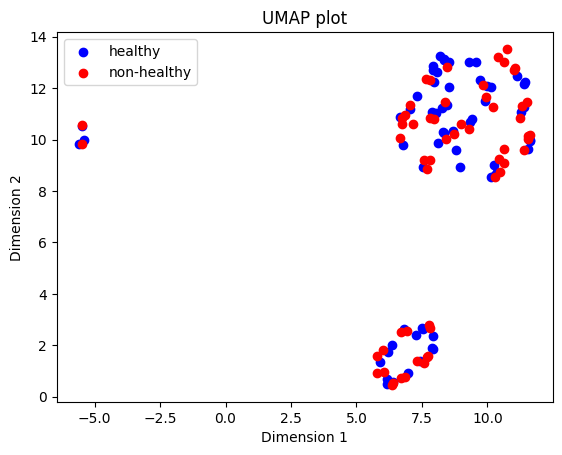

In [23]:
plt.scatter(umap_df.loc[healthy_indices[1:]][0], umap_df.loc[healthy_indices[1:]][1], c = 'blue', label='healthy')
plt.scatter(umap_df.loc[non_indices[1:]][0], umap_df.loc[non_indices[1:]][1], c = 'red', label = 'non-healthy')

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('UMAP plot')
plt.legend()

# Step 3

## DESeq Boogaloo

In [19]:
metadata_df = pd.read_csv('SRP158491/metadata_SRP158491.tsv', sep='\t')

In [20]:
metadata_df_healthy = metadata_df.loc[metadata_df['refinebio_disease'] == 'healthy']
metadata_df_unhealthy = metadata_df.loc[metadata_df['refinebio_disease'] == 'ra non treatment']

In [21]:
metadata_df = pd.concat([metadata_df_healthy, metadata_df_unhealthy])

In [22]:
metadata_df

,refinebio_accession_code,experiment_accession,refinebio_age,refinebio_cell_line,refinebio_compound,refinebio_developmental_stage,refinebio_disease,refinebio_disease_stage,refinebio_genetic_information,refinebio_organism,...,refinebio_processor_version,refinebio_race,refinebio_sex,refinebio_source_archive_url,refinebio_source_database,refinebio_specimen_part,refinebio_subject,refinebio_time,refinebio_title,refinebio_treatment
0,SRR7725764,SRP158491,53.0,NaN,NaN,NaN,healthy,NaN,NaN,HOMO_SAPIENS,...,v1.26.0-hotfix,NaN,male,NaN,SRA,blood,tcm cd4 cell,NaN,HC1__CD4-Tcm cells,NaN
1,SRR7725765,SRP158491,53.0,NaN,NaN,NaN,healthy,NaN,NaN,HOMO_SAPIENS,...,v1.26.0-hotfix,NaN,male,NaN,SRA,blood,tem cd4 cell,NaN,HC1__CD4-Tem cells,NaN
2,SRR7725767,SRP158491,53.0,NaN,NaN,NaN,healthy,NaN,NaN,HOMO_SAPIENS,...,v1.26.0-hotfix,NaN,male,NaN,SRA,blood,tcm cd8 cell,NaN,HC1__CD8-Tcm cells,NaN
3,SRR7725768,SRP158491,53.0,NaN,NaN,NaN,healthy,NaN,NaN,HOMO_SAPIENS,...,v1.26.0-hotfix,NaN,male,NaN,SRA,blood,tem cd8 cell,NaN,HC1__CD8-Tem cells,NaN
4,SRR7725770,SRP158491,53.0,NaN,NaN,NaN,healthy,NaN,NaN,HOMO_SAPIENS,...,v1.26.0-hotfix,NaN,male,NaN,SRA,blood,tn cd8 cell,NaN,HC1__CD8-Tn cells,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
216,SRR7726017,SRP158491,48.0,NaN,NaN,NaN,ra non treatment,NaN,NaN,HOMO_SAPIENS,...,v1.26.0-hotfix,NaN,male,NaN,SRA,blood,tn cd4 cell,NaN,RA_non treated9__CD4-Tn cells,NaN
217,SRR7726018,SRP158491,48.0,NaN,NaN,NaN,ra non treatment,NaN,NaN,HOMO_SAPIENS,...,v1.26.0-hotfix,NaN,male,NaN,SRA,blood,tcm cd8 cell,NaN,RA_non treated9__CD8-Tcm cells,NaN
218,SRR7726019,SRP158491,48.0,NaN,NaN,NaN,ra non treatment,NaN,NaN,HOMO_SAPIENS,...,v1.26.0-hotfix,NaN,male,NaN,SRA,blood,tem cd8 cell,NaN,RA_non treated9__CD8-Tem cells,NaN
219,SRR7726020,SRP158491,48.0,NaN,NaN,NaN,ra non treatment,NaN,NaN,HOMO_SAPIENS,...,v1.26.0-hotfix,NaN,male,NaN,SRA,blood,temra cd8 cell,NaN,RA_non treated9__CD8-Temra cells,NaN


In [23]:
len(metadata_df['refinebio_accession_code'].unique())

119

In [24]:
deseq_df = df.set_index('Gene')

In [25]:
deseq_df = deseq_df.round(0)

In [26]:
deseq_df = deseq_df.astype(int)

In [27]:
deseq_df

,SRR7725764,SRR7725765,SRR7725767,SRR7725768,SRR7725770,SRR7725772,SRR7725773,SRR7725774,SRR7725775,SRR7725776,...,SRR7726082,SRR7726083,SRR7726089,SRR7726092,SRR7726094,SRR7726095,SRR7726096,SRR7726097,SRR7726098,SRR7726099
Gene,,,,,,,,,,,,,,,,,,,,,
TSPAN6,3,5,0,0,6,5,21,3,0,0,...,14,2,3,18,2,14,8,0,2,14
TNMD,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
DPM1,68,132,35,563,140,323,465,416,338,393,...,388,422,324,301,403,423,442,404,556,139
SCYL3,78,42,48,111,52,120,146,129,91,112,...,170,115,85,88,118,161,132,103,97,49
FIRRM,19,24,16,32,18,38,39,33,43,51,...,54,53,64,28,57,46,29,38,36,16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LOC128092249,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ARMCX5-GPRASP2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
LOC112268419,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
deseq_df.transpose()

Gene,TSPAN6,TNMD,DPM1,SCYL3,FIRRM,FGR,CFH,FUCA2,GCLC,NFYA,...,LOC728392,CPLANE1-AS1,COPG2IT1,LINC00279,NOTCH2NLC,LOC128092249,ARMCX5-GPRASP2,LOC112268419,LOC124903324,LOC114841035
SRR7725764,3,0,68,78,19,3,4,44,256,208,...,115,0,0,0,385,0,0,0,0,0
SRR7725765,5,0,132,42,24,785,23,32,343,240,...,189,0,0,0,496,0,0,0,0,0
SRR7725767,0,0,35,48,16,6,8,4,186,109,...,49,0,0,0,211,0,0,0,0,0
SRR7725768,0,0,563,111,32,1069,79,55,316,411,...,350,0,0,0,792,0,0,0,0,0
SRR7725770,6,0,140,52,18,16,0,25,282,338,...,275,0,0,0,1102,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR7726095,14,0,423,161,46,6,0,5,15,290,...,108,0,0,0,478,0,0,0,0,0
SRR7726096,8,0,442,132,29,29,10,43,155,360,...,263,0,0,0,770,0,0,0,0,0
SRR7726097,0,0,404,103,38,429,22,37,87,295,...,258,0,0,0,514,0,0,0,0,0
SRR7726098,2,1,556,97,36,1175,73,63,57,318,...,216,0,0,0,575,0,0,0,0,0


In [29]:
metadata_df.set_index('refinebio_accession_code', inplace=True)

In [30]:
metadata_df

,experiment_accession,refinebio_age,refinebio_cell_line,refinebio_compound,refinebio_developmental_stage,refinebio_disease,refinebio_disease_stage,refinebio_genetic_information,refinebio_organism,refinebio_platform,...,refinebio_processor_version,refinebio_race,refinebio_sex,refinebio_source_archive_url,refinebio_source_database,refinebio_specimen_part,refinebio_subject,refinebio_time,refinebio_title,refinebio_treatment
refinebio_accession_code,,,,,,,,,,,,,,,,,,,,,
SRR7725764,SRP158491,53.0,NaN,NaN,NaN,healthy,NaN,NaN,HOMO_SAPIENS,Ion Torrent Proton (IonTorrentProton),...,v1.26.0-hotfix,NaN,male,NaN,SRA,blood,tcm cd4 cell,NaN,HC1__CD4-Tcm cells,NaN
SRR7725765,SRP158491,53.0,NaN,NaN,NaN,healthy,NaN,NaN,HOMO_SAPIENS,Ion Torrent Proton (IonTorrentProton),...,v1.26.0-hotfix,NaN,male,NaN,SRA,blood,tem cd4 cell,NaN,HC1__CD4-Tem cells,NaN
SRR7725767,SRP158491,53.0,NaN,NaN,NaN,healthy,NaN,NaN,HOMO_SAPIENS,Ion Torrent Proton (IonTorrentProton),...,v1.26.0-hotfix,NaN,male,NaN,SRA,blood,tcm cd8 cell,NaN,HC1__CD8-Tcm cells,NaN
SRR7725768,SRP158491,53.0,NaN,NaN,NaN,healthy,NaN,NaN,HOMO_SAPIENS,Ion Torrent Proton (IonTorrentProton),...,v1.26.0-hotfix,NaN,male,NaN,SRA,blood,tem cd8 cell,NaN,HC1__CD8-Tem cells,NaN
SRR7725770,SRP158491,53.0,NaN,NaN,NaN,healthy,NaN,NaN,HOMO_SAPIENS,Ion Torrent Proton (IonTorrentProton),...,v1.26.0-hotfix,NaN,male,NaN,SRA,blood,tn cd8 cell,NaN,HC1__CD8-Tn cells,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR7726017,SRP158491,48.0,NaN,NaN,NaN,ra non treatment,NaN,NaN,HOMO_SAPIENS,Ion Torrent Proton (IonTorrentProton),...,v1.26.0-hotfix,NaN,male,NaN,SRA,blood,tn cd4 cell,NaN,RA_non treated9__CD4-Tn cells,NaN
SRR7726018,SRP158491,48.0,NaN,NaN,NaN,ra non treatment,NaN,NaN,HOMO_SAPIENS,Ion Torrent Proton (IonTorrentProton),...,v1.26.0-hotfix,NaN,male,NaN,SRA,blood,tcm cd8 cell,NaN,RA_non treated9__CD8-Tcm cells,NaN
SRR7726019,SRP158491,48.0,NaN,NaN,NaN,ra non treatment,NaN,NaN,HOMO_SAPIENS,Ion Torrent Proton (IonTorrentProton),...,v1.26.0-hotfix,NaN,male,NaN,SRA,blood,tem cd8 cell,NaN,RA_non treated9__CD8-Tem cells,NaN


In [31]:
inference = DefaultInference(n_cpus=4)
dds = DeseqDataSet(
    counts=deseq_df.transpose().loc[metadata_df.index],
    metadata=metadata_df,
    design_factors='refinebio_disease',
    refit_cooks=True,
    inference=inference
)

C:\Users\13523\AppData\Local\Temp\ipykernel_22508\1598856877.py:2: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(


In [32]:
dds.deseq2()

Fitting size factors...
... done in 0.36 seconds.

Fitting dispersions...
... done in 11.82 seconds.

Fitting dispersion trend curve...
... done in 0.81 seconds.

Fitting MAP dispersions...
... done in 13.20 seconds.

Fitting LFCs...
... done in 8.28 seconds.

Calculating cook's distance...
... done in 0.37 seconds.

Replacing 3227 outlier genes.

Fitting dispersions...
... done in 2.02 seconds.

Fitting MAP dispersions...
... done in 1.93 seconds.

Fitting LFCs...
... done in 1.58 seconds.



In [33]:
dds

AnnData object with n_obs × n_vars = 119 × 31644
    obs: 'experiment_accession', 'refinebio_age', 'refinebio_cell_line', 'refinebio_compound', 'refinebio_developmental_stage', 'refinebio-disease', 'refinebio_disease_stage', 'refinebio_genetic_information', 'refinebio_organism', 'refinebio_platform', 'refinebio_processed', 'refinebio_processor_id', 'refinebio_processor_name', 'refinebio_processor_version', 'refinebio_race', 'refinebio_sex', 'refinebio_source_archive_url', 'refinebio_source_database', 'refinebio_specimen_part', 'refinebio_subject', 'refinebio_time', 'refinebio_title', 'refinebio_treatment'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converg

In [34]:
stat_res = DeseqStats(dds, inference=inference)

I'm The GOAT 

In [35]:
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: refinebio-disease ra non treatment vs healthy
                  baseMean  log2FoldChange     lfcSE      stat    pvalue  \
Gene                                                                       
TSPAN6            6.383977        0.132367  0.383459  0.345193  0.729949   
TNMD              0.000000             NaN       NaN       NaN       NaN   
DPM1            241.680400       -0.168669  0.103023 -1.637200  0.101589   
SCYL3            75.899577       -0.085660  0.109380 -0.783142  0.433544   
FIRRM            40.036746        0.013088  0.153541  0.085244  0.932068   
...                    ...             ...       ...       ...       ...   
LOC128092249      0.000000             NaN       NaN       NaN       NaN   
ARMCX5-GPRASP2    0.088089       -0.138200  2.961894 -0.046659  0.962785   
LOC112268419      0.000000             NaN       NaN       NaN       NaN   
LOC124903324      0.157113       -0.083495  2.396260 -0.034844  0.972204   
LOC1

... done in 2.73 seconds.



1) Still need to do t_SNE and the other dimensionality reduction thing
2) Volcano Plot this Thing
3) Get the most Differentially expressed Genes

In [36]:
result_df = stat_res.results_df

In [37]:
result_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene,,,,,,
TSPAN6,6.383977,0.132367,0.383459,0.345193,0.729949,0.907981
TNMD,0.000000,NaN,NaN,NaN,NaN,NaN
DPM1,241.680400,-0.168669,0.103023,-1.637200,0.101589,0.393726
SCYL3,75.899577,-0.085660,0.109380,-0.783142,0.433544,0.758731
FIRRM,40.036746,0.013088,0.153541,0.085244,0.932068,0.981618
...,...,...,...,...,...,...
LOC128092249,0.000000,NaN,NaN,NaN,NaN,NaN
ARMCX5-GPRASP2,0.088089,-0.138200,2.961894,-0.046659,0.962785,NaN
LOC112268419,0.000000,NaN,NaN,NaN,NaN,NaN


In [38]:
results = result_df

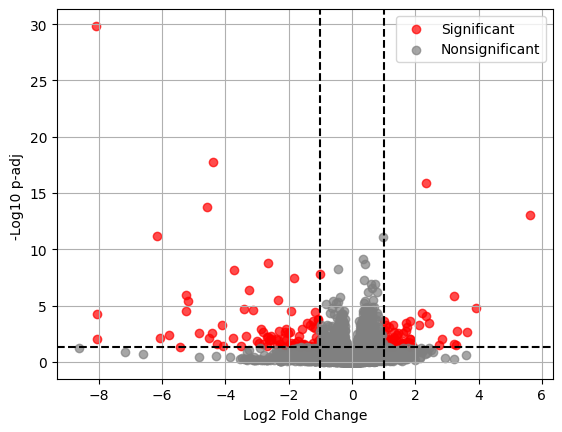

In [46]:
results['significant'] = (results['padj'] < 0.05) & (abs(results['log2FoldChange']) > 1)
results['nonsignificant'] = ~results['significant']

plt.scatter(results.loc[(results['significant']), 'log2FoldChange'],
            -np.log10(results.loc[(results['significant']), 'padj']),
            color='red', alpha=0.7, label='Significant')

plt.scatter(results.loc[(results['nonsignificant']), 'log2FoldChange'],
            -np.log10(results.loc[(results['nonsignificant']), 'padj']),
            color='grey', alpha=0.7, label='Nonsignificant')


plt.xlabel('Log2 Fold Change')
plt.ylabel('-Log10 p-adj ')
plt.axhline(y=-np.log10(0.05), color='black', linestyle='--')  # p-value threshold
plt.axvline(x=1, color='black', linestyle='--')  # Log2FC threshold
plt.axvline(x=-1, color='black', linestyle='--')

plt.legend()
# Show plot
plt.grid()
plt.show()

In [43]:
sorted_df = result_df.loc[result_df['significant']].sort_values(by='padj', ascending=True)

In [44]:
sorted_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,significant,nonsignificant
Gene,,,,,,,,
NOS3,2330.906071,-8.094863,0.658594,-12.291136,1.010761e-34,1.440031e-30,True,False
ZNF836,64.947726,-4.391821,0.452228,-9.711528,2.692698e-22,1.918144e-18,True,False
CISH,602.704209,2.324258,0.251684,9.234810,2.587458e-20,1.228784e-16,True,False
RPS27L,111.279503,-4.596313,0.530297,-8.667424,4.420057e-18,1.574314e-14,True,False
ZNF761,59.935012,5.637856,0.668229,8.437014,3.255461e-17,9.276111e-14,True,False
...,...,...,...,...,...,...,...,...
RAB5IF,1.443993,-2.248394,0.750084,-2.997524,2.721824e-03,4.781483e-02,True,False
SEMA6B,20.772086,1.920652,0.640875,2.996924,2.727185e-03,4.785001e-02,True,False
THBS1,34.948199,-1.404682,0.468768,-2.996540,2.730625e-03,4.785143e-02,True,False


In [67]:
top50 = sorted_df.iloc[:50]

In [68]:
top50

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,significant,nonsignificant
Gene,,,,,,,,
NOS3,2330.906071,-8.094863,0.658594,-12.291136,1.010761e-34,1.440031e-30,True,False
ZNF836,64.947726,-4.391821,0.452228,-9.711528,2.692698e-22,1.918144e-18,True,False
CISH,602.704209,2.324258,0.251684,9.234810,2.587458e-20,1.228784e-16,True,False
RPS27L,111.279503,-4.596313,0.530297,-8.667424,4.420057e-18,1.574314e-14,True,False
ZNF761,59.935012,5.637856,0.668229,8.437014,3.255461e-17,9.276111e-14,True,False
ADGRE2,76.129904,-6.167012,0.780685,-7.899488,2.800516e-15,6.649825e-12,True,False
PAM,60.897736,-2.669454,0.374907,-7.120305,1.076882e-12,1.704704e-09,True,False
FARP1,23.669595,-3.738833,0.543493,-6.879260,6.016411e-12,7.142984e-09,True,False
CFAP45,18.262407,-1.005364,0.148612,-6.765023,1.332879e-11,1.460733e-08,True,False


In [31]:
sorted_df = sorted_df.dropna(subset='log2FoldChange')

In [40]:
sorted_df.to_csv('most_significant.csv')

In [45]:
sorted_df[:50].to_csv('50most-significant.csv')

In [46]:
sorted_df[:50]

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene,,,,,,
NOS3,2330.906071,-8.094863,0.658594,-12.291136,1.010761e-34,1.440031e-30
ZNF836,64.947726,-4.391821,0.452228,-9.711528,2.692698e-22,1.918144e-18
CISH,602.704209,2.324258,0.251684,9.234810,2.587458e-20,1.228784e-16
RPS27L,111.279503,-4.596313,0.530297,-8.667424,4.420057e-18,1.574314e-14
ZNF761,59.935012,5.637856,0.668229,8.437014,3.255461e-17,9.276111e-14
ADGRE2,76.129904,-6.167012,0.780685,-7.899488,2.800516e-15,6.649825e-12
PIM1,1739.350184,0.989661,0.126143,7.845568,4.309989e-15,8.772059e-12
IRF2,763.351337,0.335074,0.046210,7.251061,4.135179e-13,7.364236e-10
PAM,60.897736,-2.669454,0.374907,-7.120305,1.076882e-12,1.704704e-09


# Step 4

In [61]:
normalized_counts_df = deseq2_norm(deseq_df.transpose().loc[metadata_df.index])[0]

In [64]:
normalized_counts_df

refinebio_accession_code,SRR7725764,SRR7725765,SRR7725767,SRR7725768,SRR7725770,SRR7725772,SRR7725773,SRR7725774,SRR7725775,SRR7725776,...,SRR7726011,SRR7726012,SRR7726013,SRR7726014,SRR7726015,SRR7726017,SRR7726018,SRR7726019,SRR7726020,SRR7726021
Gene,,,,,,,,,,,,,,,,,,,,,
TSPAN6,4.632431,5.405833,0.000000,0.000000,6.475645,4.046073,18.000476,2.467177,0.000000,0.000000,...,2.671056,0.000000,0.000000,3.989336,4.064965,19.913654,7.255488,0.000000,0.000000,5.896936
TNMD,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
DPM1,105.001765,142.713989,95.726994,280.765929,151.098392,261.376320,398.581978,342.115278,301.398201,275.617611,...,323.197731,203.475454,114.730411,371.008258,278.450125,293.173236,314.058966,360.722643,287.312667,308.999470
SCYL3,120.443201,45.408997,131.282735,55.355272,56.122260,97.105754,125.146169,106.088632,81.145669,78.547513,...,94.377299,63.184483,34.419123,102.924872,91.461720,94.036698,162.730223,89.703514,98.291176,117.938729
FIRRM,29.338729,25.947998,43.760912,15.958277,19.426936,30.750155,33.429456,27.138952,38.343558,35.767171,...,33.833371,35.340474,42.614153,23.936017,18.292344,39.827308,38.350435,72.526246,54.438190,38.919781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
LOC128092249,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
ARMCX5-GPRASP2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
LOC112268419,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [73]:
normalized_counts_df = normalized_counts_df.transpose()

In [75]:
normalized_counts_df = normalized_counts_df.loc[sorted_df.index]

In [84]:
normalized_counts_df

refinebio_accession_code,SRR7725764,SRR7725765,SRR7725767,SRR7725768,SRR7725770,SRR7725772,SRR7725773,SRR7725774,SRR7725775,SRR7725776,...,SRR7726011,SRR7726012,SRR7726013,SRR7726014,SRR7726015,SRR7726017,SRR7726018,SRR7726019,SRR7726020,SRR7726021
Gene,,,,,,,,,,,,,,,,,,,,,
NOS3,35.515303,9.730499,19.145399,4.488265,9.713468,6.473717,16.286145,18.915027,3.566843,0.000000,...,14.245630,4.283694,0.000000,19.148813,10.839908,25.445224,7.255488,12.405805,3.780430,4.717549
ZNF836,7.720718,5.405833,2.735057,8.477834,42.091695,4.046073,0.857166,4.111962,1.783421,1.402634,...,4.451759,6.425541,3.278012,2.393602,2.032483,11.063141,3.109495,11.451512,4.536516,2.358775
CISH,149.781930,109.197825,60.171254,55.355272,260.105089,240.336740,627.445178,338.825708,118.597517,96.781757,...,645.505111,409.092756,319.606145,1042.014591,488.473333,799.865093,350.336404,212.807273,176.924116,653.380560
RPS27L,6.176574,9.730499,79.316653,2.992177,8.634194,1.618429,6.000159,0.000000,0.891711,4.909220,...,1.780704,170.276828,9.834035,1.595734,4.742460,3.318942,2.072996,14.314391,13.609547,1.179387
ZNF761,12.353149,4.324666,8.205171,0.000000,4.317097,0.809215,0.000000,0.000000,0.891711,0.701317,...,0.890352,491.553861,4.917018,0.797867,0.000000,3.318942,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RAB5IF,0.000000,2.162333,0.000000,0.997392,0.000000,0.000000,0.857166,0.000000,2.675132,0.000000,...,0.000000,0.000000,6.556023,0.000000,0.000000,0.000000,0.000000,0.000000,1.512172,0.000000
SEMA6B,35.515303,1.081167,65.641368,0.997392,9.713468,0.000000,0.000000,0.000000,3.566843,0.000000,...,0.890352,14.992928,91.784329,0.000000,0.677494,0.000000,0.000000,1.908585,0.000000,4.717549
THBS1,20.073867,102.710826,16.410342,356.069047,0.000000,49.362091,0.000000,13.158280,40.126979,51.897464,...,25.820204,84.602952,49.170176,2.393602,4.064965,0.000000,6.218989,18.131561,27.219095,0.000000


In [85]:
metadata_df

,experiment_accession,refinebio_age,refinebio_cell_line,refinebio_compound,refinebio_developmental_stage,refinebio_disease,refinebio_disease_stage,refinebio_genetic_information,refinebio_organism,refinebio_platform,...,refinebio_processor_version,refinebio_race,refinebio_sex,refinebio_source_archive_url,refinebio_source_database,refinebio_specimen_part,refinebio_subject,refinebio_time,refinebio_title,refinebio_treatment
refinebio_accession_code,,,,,,,,,,,,,,,,,,,,,
SRR7725764,SRP158491,53.0,NaN,NaN,NaN,healthy,NaN,NaN,HOMO_SAPIENS,Ion Torrent Proton (IonTorrentProton),...,v1.26.0-hotfix,NaN,male,NaN,SRA,blood,tcm cd4 cell,NaN,HC1__CD4-Tcm cells,NaN
SRR7725765,SRP158491,53.0,NaN,NaN,NaN,healthy,NaN,NaN,HOMO_SAPIENS,Ion Torrent Proton (IonTorrentProton),...,v1.26.0-hotfix,NaN,male,NaN,SRA,blood,tem cd4 cell,NaN,HC1__CD4-Tem cells,NaN
SRR7725767,SRP158491,53.0,NaN,NaN,NaN,healthy,NaN,NaN,HOMO_SAPIENS,Ion Torrent Proton (IonTorrentProton),...,v1.26.0-hotfix,NaN,male,NaN,SRA,blood,tcm cd8 cell,NaN,HC1__CD8-Tcm cells,NaN
SRR7725768,SRP158491,53.0,NaN,NaN,NaN,healthy,NaN,NaN,HOMO_SAPIENS,Ion Torrent Proton (IonTorrentProton),...,v1.26.0-hotfix,NaN,male,NaN,SRA,blood,tem cd8 cell,NaN,HC1__CD8-Tem cells,NaN
SRR7725770,SRP158491,53.0,NaN,NaN,NaN,healthy,NaN,NaN,HOMO_SAPIENS,Ion Torrent Proton (IonTorrentProton),...,v1.26.0-hotfix,NaN,male,NaN,SRA,blood,tn cd8 cell,NaN,HC1__CD8-Tn cells,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR7726017,SRP158491,48.0,NaN,NaN,NaN,ra non treatment,NaN,NaN,HOMO_SAPIENS,Ion Torrent Proton (IonTorrentProton),...,v1.26.0-hotfix,NaN,male,NaN,SRA,blood,tn cd4 cell,NaN,RA_non treated9__CD4-Tn cells,NaN
SRR7726018,SRP158491,48.0,NaN,NaN,NaN,ra non treatment,NaN,NaN,HOMO_SAPIENS,Ion Torrent Proton (IonTorrentProton),...,v1.26.0-hotfix,NaN,male,NaN,SRA,blood,tcm cd8 cell,NaN,RA_non treated9__CD8-Tcm cells,NaN
SRR7726019,SRP158491,48.0,NaN,NaN,NaN,ra non treatment,NaN,NaN,HOMO_SAPIENS,Ion Torrent Proton (IonTorrentProton),...,v1.26.0-hotfix,NaN,male,NaN,SRA,blood,tem cd8 cell,NaN,RA_non treated9__CD8-Tem cells,NaN


In [82]:
log_counts_df = np.log1p(normalized_counts_df)

# Standardize the data using z-score normalization
scaler = StandardScaler()
scaled_counts = scaler.fit_transform(log_counts_df.T).T  # Transpose before and after scaling
scaled_counts_df = pd.DataFrame(scaled_counts, index=log_counts_df.index, columns=log_counts_df.columns)

In [86]:
gene_labels = metadata_df['refinebio_disease']

In [88]:
lut = {'healthy': 'green', 'ra non treatment': 'purple'}
row_colors = gene_labels.map(lut)

In [102]:
scaled_counts_df.columns.name = 'Sample'

In [105]:
row_colors.name = 'Sample group'

<Figure size 5000x5000 with 0 Axes>

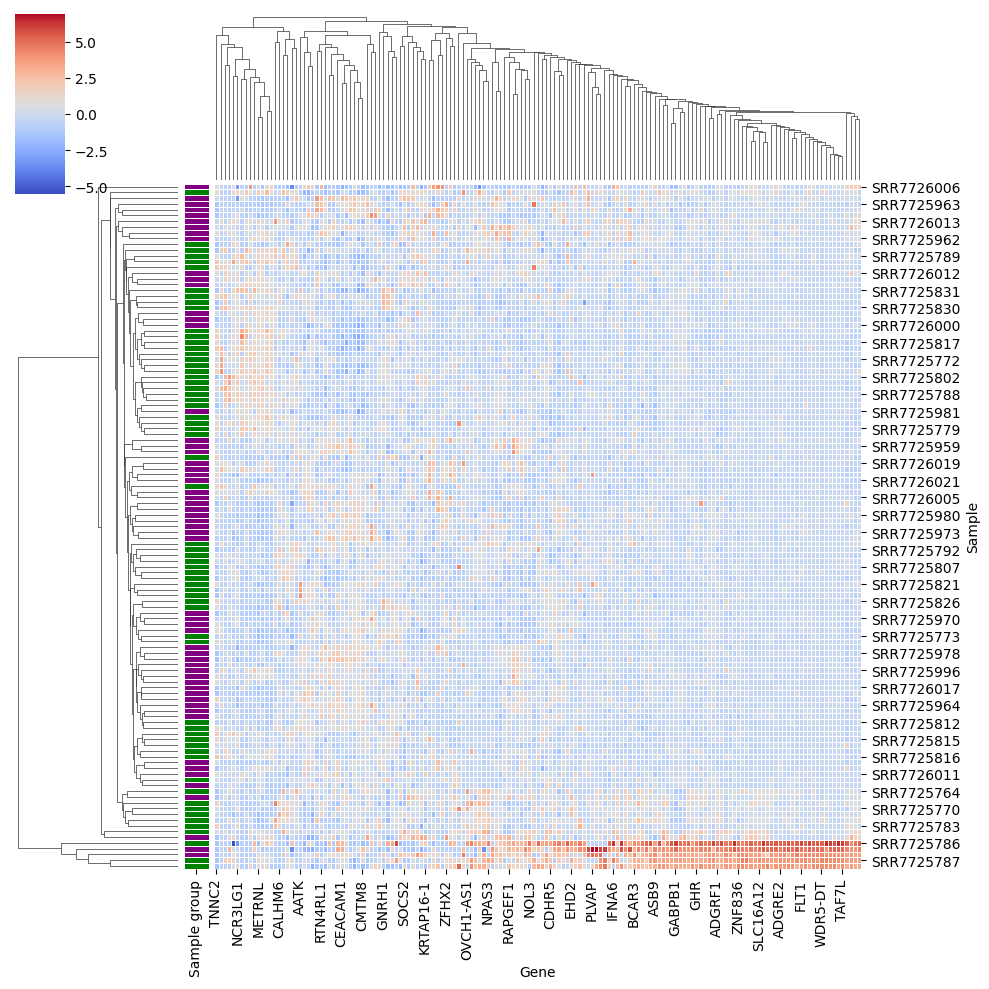

In [106]:
plt.figure(figsize=(50, 50))

# Use seaborn to create the heatmap
sns.clustermap(scaled_counts_df.transpose(), row_colors=row_colors, cmap="coolwarm", linewidths=0.5)

# Show the heatmap
plt.show()

# Step 5

In [41]:
lmao = pd.read_csv('enrichment.csv')

In [42]:
lmao

,Unnamed: 0,ID,Description,setSize,enrichmentScore,NES,pvalue,p.adjust,qvalue,rank,leading_edge,core_enrichment
0,GO:0035924,GO:0035924,cellular response to vascular endothelial grow...,61,-0.770573,-2.327384,8.444344e-09,0.000052,0.000050,866,"tags=20%, list=4%, signal=19%",2322/3592/2324/9270/8828/10253/207/7422/7412/2...
1,GO:0038084,GO:0038084,vascular endothelial growth factor signaling p...,43,-0.789900,-2.255355,5.190160e-07,0.001587,0.001548,866,"tags=21%, list=4%, signal=20%",2322/3592/2324/8828/10253/7422/2321/7424/3791
2,GO:0043536,GO:0043536,positive regulation of blood vessel endothelia...,54,-0.732333,-2.168813,4.604187e-06,0.007772,0.007580,268,"tags=11%, list=1%, signal=11%",7057/207/7422/7424/3791/4846
3,GO:0010595,GO:0010595,positive regulation of endothelial cell migration,101,-0.623355,-2.034093,5.083611e-06,0.007772,0.007580,595,"tags=12%, list=3%, signal=12%",23328/2324/54453/84913/7057/9270/8828/207/7422...
4,GO:0048010,GO:0048010,vascular endothelial growth factor receptor si...,53,-0.707245,-2.093873,1.083039e-05,0.011038,0.010766,595,"tags=11%, list=3%, signal=11%",2324/2254/7422/2321/7424/3791
5,GO:0097529,GO:0097529,myeloid leukocyte migration,214,-0.510672,-1.820593,1.016430e-05,0.011038,0.010766,2936,"tags=22%, list=14%, signal=20%",7857/6361/2683/5734/10563/5473/728/2813/2526/1...
6,GO:0001936,GO:0001936,regulation of endothelial cell proliferation,127,-0.578299,-1.949937,1.725087e-05,0.013186,0.012861,752,"tags=9%, list=3%, signal=9%",1012/3592/2324/84913/7057/8828/6347/207/7422/2...
7,GO:0033674,GO:0033674,positive regulation of kinase activity,288,-0.469749,-1.734464,1.717363e-05,0.013186,0.012861,2732,"tags=20%, list=13%, signal=18%",84630/10006/5580/7564/6997/11314/4504/9928/190...
8,GO:0001935,GO:0001935,endothelial cell proliferation,148,-0.551376,-1.892832,2.612645e-05,0.017751,0.017314,752,"tags=9%, list=3%, signal=9%",1012/3592/2324/84913/7057/9270/8828/6347/207/7...
9,GO:0007608,GO:0007608,sensory perception of smell,392,-0.435127,-1.646584,2.927889e-05,0.017904,0.017463,2193,"tags=18%, list=10%, signal=16%",26188/254783/8195/390152/284383/26533/390174/8...


In [8]:
what = pd.read_csv('most_significant-billzhao.csv', index_col=0)

In [9]:
what

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
Gene,,,,,,
NOS3,2330.906071,-8.094863,0.658594,-12.291136,1.010761e-34,1.440031e-30
ZNF836,64.947726,-4.391821,0.452228,-9.711528,2.692698e-22,1.918144e-18
CISH,602.704209,2.324258,0.251684,9.234810,2.587458e-20,1.228784e-16
RPS27L,111.279503,-4.596313,0.530297,-8.667424,4.420057e-18,1.574314e-14
ZNF761,59.935012,5.637856,0.668229,8.437014,3.255461e-17,9.276111e-14
...,...,...,...,...,...,...
LOC105372401,0.035013,-0.138200,2.961894,-0.046659,9.627848e-01,NaN
FLICR,0.047199,0.250436,2.961270,0.084570,9.326029e-01,NaN
COPG2IT1,0.012163,-0.049206,2.966228,-0.016589,9.867648e-01,NaN


In [10]:
what['log2FoldChange'].nunique()

18506

(array([1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

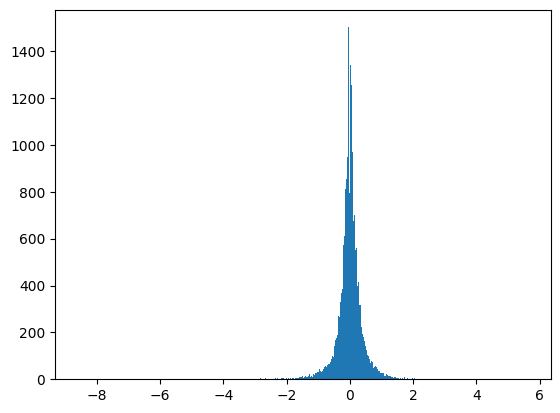

In [12]:
plt.hist(what['log2FoldChange'], bins = 500)

In [14]:
pip install gseapy

   ---------------------------------------- 0.0/383.9 kB ? eta -:--:--
   ------------------------- -------------- 245.8/383.9 kB 5.0 MB/s eta 0:00:01
   ---------------------------------------- 383.9/383.9 kB 4.8 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: C:\Users\13523\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [15]:
import gseapy as gp

In [16]:
gene_sets = ['GO_Biological_Process_2021']

In [ ]:
enr = gp.enrich(
    gene_list = significant_genes,
    gene_sets = gene_sets,
    organism = 'Human',
    outdir = 'gseapy_enrichr_results',
    cutoff = 0.05
)